# Импортирование необходимых библиотек

In [65]:
from sentinelhub import SHConfig
from sentinelhub import SentinelHubCatalog

import datetime, os, csv, math
from datetime import timezone, timedelta
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
from shapely.ops import unary_union
from fiona.drvsupport import supported_drivers
import geopandas as gpd
from matplotlib.path import Path
from shapely.geometry import Polygon
import earthpy.spatial as es
import earthpy.plot as ep
import numpy.ma as ma
from scipy.stats.mstats import gmean, hmean
import pandas as pd
import seaborn as sns
from functools import reduce
from itertools import tee, zip_longest

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib.colors import ListedColormap

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    filter_times
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan']


import csv, json, codecs, sys
import urllib.request
import urllib.error
import pandas as pd

import requests
from bs4 import BeautifulSoup

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
sns.set()

# Подключение к аккаунту Sentinel Hub

In [3]:
CLIENT_ID = os.getenv('CLIENT_ID')
CLIENT_SECRET = os.environ.get('CLIENT_SECRET')

config = SHConfig()

if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [4]:
catalog = SentinelHubCatalog(config=config)
# catalog.get_info()

# Получение координат экспериментального пастбища 

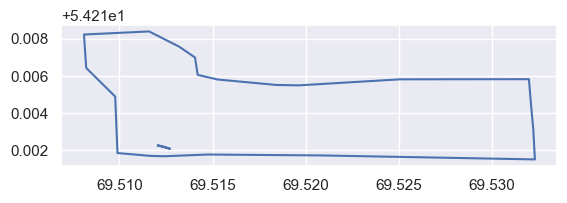

In [5]:
supported_drivers['KML'] = 'rw'
pasture_df = gpd.read_file('pasture.kml', driver='KML')

all_zagons = []
for zagon in range(len(pasture_df.index)):
    all_zagons.append(pasture_df.loc[zagon].geometry)
    
merged_zagons = unary_union(all_zagons)

gpd.GeoSeries([merged_zagons]).boundary.plot()
plt.show()

In [6]:
x_min, y_min, x_max, y_max = merged_zagons.bounds
pasture_coords_wgs84 = (x_min, y_min, x_max, y_max)

# Отправка запросов и получение снимков 

In [7]:
resolution = 10
pasture_bbox = BBox(bbox=pasture_coords_wgs84, crs=CRS.WGS84)
pasture_size = bbox_to_dimensions(pasture_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {pasture_size} pixels")

Image shape at 10 m resolution: (157, 78) pixels


# Доступные базы данных (Спутиковые базы!!!)

In [8]:
print("Supported DataCollections:\n")
for collection in DataCollection.get_available_collections():
    print(collection)

Supported DataCollections:

DataCollection.SENTINEL2_L1C
DataCollection.SENTINEL2_L2A
DataCollection.SENTINEL1
DataCollection.SENTINEL1_IW
DataCollection.SENTINEL1_IW_ASC
DataCollection.SENTINEL1_IW_DES
DataCollection.SENTINEL1_EW
DataCollection.SENTINEL1_EW_ASC
DataCollection.SENTINEL1_EW_DES
DataCollection.SENTINEL1_EW_SH
DataCollection.SENTINEL1_EW_SH_ASC
DataCollection.SENTINEL1_EW_SH_DES
DataCollection.DEM
DataCollection.DEM_MAPZEN
DataCollection.DEM_COPERNICUS_30
DataCollection.DEM_COPERNICUS_90
DataCollection.MODIS
DataCollection.LANDSAT_MSS_L1
DataCollection.LANDSAT_TM_L1
DataCollection.LANDSAT_TM_L2
DataCollection.LANDSAT_ETM_L1
DataCollection.LANDSAT_ETM_L2
DataCollection.LANDSAT_OT_L1
DataCollection.LANDSAT_OT_L2
DataCollection.SENTINEL5P
DataCollection.SENTINEL3_OLCI
DataCollection.SENTINEL3_SLSTR
DataCollection.HARMONIZED_LANDSAT_SENTINEL


# Выбор одной из доступных баз данных

In [9]:
data_collection = DataCollection.SENTINEL2_L2A
bands_dict = dict([(band.name, i) for i, band in enumerate(data_collection.bands)])
aux_data_dict = dict([(band, i) for i, band in enumerate(["sunZenithAngles","sunAzimuthAngles","viewZenithMean","viewAzimuthMean"])])

# Составление запросов

In [10]:
evalscript_all_bands = """
    //VERSION=3
    function setup() {{
        return {{
            input: [{{
                bands: [{BANDS}],
                units: "DN"
            }}],
            output: {{
                bands: {COUNT},
                sampleType: "FLOAT32"
            }}
        }};
    }}

    function evaluatePixel(sample) {{
        return [{SAMPLE}];
    }}
"""
template1 = ""; template2 = ""
for band in bands_dict.keys(): 
    template1 += f'"{band}", '; 
    template2 += f'sample.{band}, ';
settings = {"BANDS": template1, "SAMPLE": template2, "COUNT": str(len(bands_dict))}
evalscript_all_bands = evalscript_all_bands.format(**settings)

In [11]:
evalscript_aux_data = """
    //VERSION=3

    function setup() {{
        return {{
            input: [{{
                bands: [{BANDS}],
                units: "DEGREES"
            }}],
            output: {{
                bands: {COUNT},
                sampleType: "FLOAT32"
            }}
        }};
    }}

    function evaluatePixel(sample) {{
        return [{SAMPLE}];
    }}
"""
template1 = ""; template2 = ""
for band in aux_data_dict.keys(): 
    template1 += f'"{band}", '; 
    template2 += f'sample.{band}, ';
settings = {"BANDS": template1, "SAMPLE": template2, "COUNT": str(len(aux_data_dict))}
evalscript_aux_data = evalscript_aux_data.format(**settings)

# Снимки на даты (с 01.05.2022 по 31.08.2022)

In [12]:
time_interval = "2022-05-01", "2022-08-31"

search_iterator = catalog.search(
    data_collection,
    bbox=pasture_bbox,
    time=time_interval,
    filter="eo:cloud_cover <= 100",
    fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
)

results = list(search_iterator)
print("Total number of results:", len(results))

# results

Total number of results: 49


In [13]:
time_difference = datetime.timedelta(hours=1)

all_timestamps = search_iterator.get_timestamps()
unique_acquisitions = filter_times(all_timestamps, time_difference)

# unique_acquisitions

In [14]:
all_bands_process_requests = []

for timestamp in unique_acquisitions:
    request = SentinelHubRequest(
        evalscript=evalscript_all_bands,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=data_collection,
                time_interval=(timestamp - time_difference, timestamp + time_difference),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=pasture_bbox,
        size=pasture_size,
        config=config,
    )
    all_bands_process_requests.append(request)

In [15]:
aux_data_process_requests = []

for timestamp in unique_acquisitions:
    request = SentinelHubRequest(
        evalscript=evalscript_aux_data,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=data_collection,
                time_interval=(timestamp - time_difference, timestamp + time_difference),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=pasture_bbox,
        size=pasture_size,
        config=config,
    )
    aux_data_process_requests.append(request)

In [16]:
%%time

client = SentinelHubDownloadClient(config=config)
all_bands_download_requests = [request.download_list[0] for request in all_bands_process_requests]
all_bands_data = client.download(all_bands_download_requests)

Wall time: 5.93 s


In [17]:
%%time

client = SentinelHubDownloadClient(config=config)
aux_data_download_requests = [request.download_list[0] for request in aux_data_process_requests]
aux_data = client.download(aux_data_download_requests)

Wall time: 6.75 s


# Составление маски пастбища

In [18]:
 aoi_height, aoi_width, _ = all_bands_data[-1].shape

In [19]:
masks = []
pasture_edges = []
for zagon in range(len(pasture_df)-1):
    polygon=[]

    for coords in pasture_df.loc[zagon].geometry.exterior.coords:

        x = int(np.interp(coords[0], [x_min, x_max], [0, aoi_width]))
        y = int(np.interp(coords[1], [y_min, y_max], [aoi_height, 0]))

        polygon.append((y, x))
        
    poly_path=Path(polygon)
    x, y = np.mgrid[:aoi_height, :aoi_width]
    coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1)))
    
    pasture_edges.append(Polygon(polygon))
    
    mask = ~poly_path.contains_points(coors)
    masks.append(mask)
    
combined_mask = reduce(np.logical_and, masks)

# Маска для загона №1 

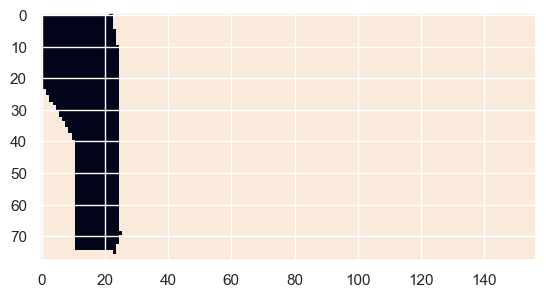

In [20]:
plt.imshow(masks[0].reshape(aoi_height, aoi_width))
plt.show()

# Маска для пастбища

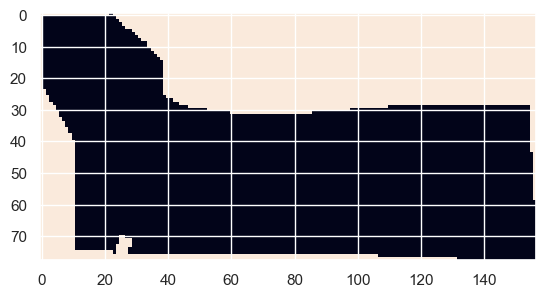

In [21]:
plt.imshow(combined_mask.reshape(aoi_height, aoi_width))
plt.show()

# Объявление вспомогательных функции

In [100]:
weights = {
    'temperature_2m_max': 0.9,
    'temperature_2m_min': 0.9,
    'apparent_temperature_max': 0.9,
    'apparent_temperature_min': 0.9,
    'precipitation_sum': 0.9,
    'rain_sum': 0.9,
    'snowfall_sum': 0.1,
    'precipitation_hours': 0.1,
    'windspeed_10m_max': 0.1,
    'winddirection_10m_dominant': 0.1,
    'shortwave_radiation_sum': 0.9,
    'et0_fao_evapotranspiration': 0.9,
    'sunZenithAngles': 1,
    'sunAzimuthAngles': 1,
    'viewZenithMean': 0.9,
    'viewAzimuthMean': 0.9,
}

def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band - band_min)/((band_max - band_min)))

def brighten(band):
    alpha=0.13
    beta=0
    return np.clip(alpha*band+beta, 0, 255)

def Kcluster(matrix, n_clusters=3):
#     scaler = MinMaxScaler(); matrix = scaler.fit_transform(matrix);
#     scaler = StandardScaler(); matrix = scaler.fit_transform(matrix);

    flattened_matrix = matrix.flatten()

    kmeans = KMeans(n_clusters=n_clusters, random_state=45)
    kmeans.fit(flattened_matrix.reshape(-1, 1))

    cluster_labels = kmeans.labels_
    result_index = cluster_labels.reshape(matrix.shape)
    result_index = ma.masked_array(result_index, mask=combined_mask.reshape(aoi_height, aoi_width))

    return ~(result_index == 0), ~(result_index == 1), ~(result_index == 2) 

def get_only_pasture(index):
    only_pasture = ma.masked_array(ma.masked_array((index), mask=np.isinf((index)) | np.isnan((index))), mask=combined_mask.reshape(aoi_height, aoi_width))
    return only_pasture

def get_only_zagon(index, zagon):
    only_zagon = ma.masked_array(ma.masked_array((index), mask=np.isinf((index)) | np.isnan((index))), mask=masks[zagon-1].reshape(aoi_height, aoi_width))
    return only_zagon

def change_difference(days_diff, zagon):
    if zagon > 0:
        return get_only_zagon(days_diff, zagon)
    else:
        return days_diff
    
def mean(index):
    return float(index.mean())

def median(index):
    return float(ma.median(index))

def get_date_slice(data, start_date, end_date):
    start_dt = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    end_dt = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    result = {
        key: value
        for key, value in data.items()
        if start_dt <= datetime.datetime.strptime(key, '%Y-%m-%d') <= end_dt
    }
    return result

def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return zip_longest(a, b)

def show_real_pasture():    
    fig, ax = plt.subplots(figsize=(12, 6))
    for zagon in range(len(pasture_df)-1):
        ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])
    ep.plot_rgb(np.stack([RED, GREEN, BLUE]), ax=ax, title=general_info, figsize=(12, 6))
    plt.show()    

    
def show_pasture_index(test_meet, lower_bound, upper_bound, show_hists=True, save_excel=False, show_index=True, show_table=True):
    precision = 4
    
    if show_index:
        fig, ax = plt.subplots(figsize=(12, 12))
        for zagon in range(len(pasture_df)-1):

            ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

        header = input_text
        # print(f"Макс: {round(float(test_meet.max()),precision)} || Мин: {round(float(test_meet.min()),precision)} || Сред: {round(float(test_meet.mean()),precision)} || Сумм: {round(float(test_meet.sum()),precision)}")
        ep.plot_bands(test_meet, title=f"{header} {general_info}", ax=ax, cmap="bwr", cols=1, vmin=lower_bound, vmax=upper_bound, figsize=(10, 14))
        plt.show()

    test_index_masked_array = []
    for i, mask in enumerate(masks):
        mx = ma.masked_array(test_meet, mask=mask.reshape(aoi_height, aoi_width))
        test_index_masked_array.append(mx)


    weather_parameters = history_df[history_df["time"]==date_chosen]

    weather_parameters = weather_parameters.assign(
        sunZenithAngles=SZA,
        sunAzimuthAngles=SAA,
        viewZenithMean=VZM,
        viewAzimuthMean=VAM)
    
    weather_parameters = weather_parameters.drop(columns=["time"], inplace=False)
    weighted_vector = (weather_parameters * pd.Series(weights)).sum(axis=1)
    weighted_vector
    
    NWC = (float(weighted_vector.iloc[0]) - 393.2550463180542) / (590.1110732021332 - 393.2550463180542)
    
    summary_data = []
    for i, zagon in enumerate(test_index_masked_array):
#         resource = round(8.59 * ma.median(zagon) + 0.20 * NWC + -7.04, precision)    

        temp_resource = 8.87 * ma.median(zagon) + 0.03 * alter_weather_param_df["temp"].iloc[0] -7.91 # (Temperature)
        press_resource = 9.12 * ma.median(zagon) -0.01 * alter_weather_param_df["pressure"].iloc[0] + 2.18 # (Pressure)
        humid_resource = 8.49 * ma.median(zagon) -0.00 * alter_weather_param_df["humidity"].iloc[0] -6.66 # (Moisture)
        angle_resource = 8.95 * ma.median(zagon) -0.03 * (SZA + VZM) -6.06 # (SZA + VZM = RZA)
        
        resource = round(np.array([temp_resource, press_resource, humid_resource, angle_resource]).mean(), precision)
        
        summary_data.append([f"№{i+1}", round(zagon.sum(),precision), round(zagon.mean(),precision), round(ma.median(zagon),precision), round(zagon.max(),precision), round(zagon.min(),precision), round(ma.count(zagon)*(10**2)*0.0001,precision), resource])


    styles = [
        {'selector': '',
         'props': [('border', '2px solid #000'), ('border-collapse', 'collapse')]},
        {'selector': 'th',
         'props': [('border', '2px solid #000')]},
        {'selector': 'td',
         'props': [('border', '1px solid #000'), ('padding', '5px')]}
    ]

    summary_df = pd.DataFrame(data = summary_data, columns=["Загон", "Сумма", "Cреднаяя", "Медианная", "Макс", "Мин", "Площадь (га)", "Ресурс (т/га)"])
    sum_row = pd.DataFrame({'Загон': ["Пастбище"], 'Сумма': [summary_df['Сумма'].sum()], 'Cреднаяя': [round(float(test_meet.mean()),precision)], 'Медианная': [round(float(ma.median(test_meet)),precision)], 'Макс': [summary_df['Макс'].max()], 'Мин': [summary_df['Мин'].min()], 'Площадь (га)': [summary_df['Площадь (га)'].sum()], 'Ресурс (т/га)': [summary_df['Ресурс (т/га)'].sum()]}, index=[len(summary_df.index)])
    summary_df = pd.concat([summary_df, sum_row])
    if save_excel:
        summary_df.to_excel(f"Summary_{date_chosen}_{data_collection.processing_level}.xlsx", index=None)
    styled_df = summary_df.style.set_table_styles(styles)
    styled_df.hide(axis="index")
    
    if show_table:
        display(styled_df)

    if show_hists:
        for i, zagon in enumerate(test_index_masked_array):
            ep.hist(zagon, colors = colors[i], title=f'{header} || Загон-{i+1} {general_info}', cols=4, alpha=0.5,
            figsize = (10, 6))    
            plt.axvline(test_index_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
            plt.axvline(ma.median(test_index_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
            has_negative_or_zero = test_index_masked_array[i] <= 0
            if not has_negative_or_zero.sum():
                plt.axvline(hmean(test_index_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
                plt.axvline(gmean(test_index_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
                plt.legend([f"Средняя: {test_index_masked_array[i].mean()}",f"Медианная: {ma.median(test_index_masked_array[i])}",f"Гармоническая: {hmean(test_index_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(test_index_masked_array[i].reshape(aoi_width * aoi_height))}"], title=f'Сумма: {round(zagon.sum(),precision)}')
            else:
                plt.legend([f"Средняя: {ma.mean(test_index_masked_array[i])}",f"Медианная: {ma.median(test_index_masked_array[i])}"], title=f'Сумма: {round(zagon.sum(),precision)}')
        plt.show()
        
        
def get_all_bands(by_pasture=False):
    global ULTRA_BLUE, BLUE, GREEN, RED, RED_EDGE1, RED_EDGE2, RED_EDGE3, NIR, N_NIR, WV, SWIR_C, SWIR2, SWIR3, SAA, SZA, VAM, VZM
    
    if by_pasture:
        # Нормализированные по пастбищу
        ULTRA_BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B12"]])))
    else:
        # НЕ Нормализированные по пастбищу
        ULTRA_BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B12"]])))

    SAA = (aux_data[image_date][:, :, aux_data_dict["sunAzimuthAngles"]]).mean()
    SZA = (aux_data[image_date][:, :, aux_data_dict["sunZenithAngles"]]).mean()
    VAM = (aux_data[image_date][:, :, aux_data_dict["viewAzimuthMean"]]).mean()
    VZM = (aux_data[image_date][:, :, aux_data_dict["viewZenithMean"]]).mean()

# Выбор порога облачности

In [23]:
# cloud_brightness_percent = 40 # %
# cloud_coverage_percent = 1 # %

# white_noise_threshold = int(np.interp(cloud_brightness_percent, [0, 100], [0, 255]))
# white_noise_count = int(np.interp(cloud_coverage_percent, [0, 100], [0, (aoi_height*aoi_width)]))

white_noise_threshold = 255 # 50
white_noise_count = 12246 # 300 / 12246

In [24]:
image_date_cloud = []
for date in unique_acquisitions:
    for index in range(len(results)):
        if datetime.datetime.strptime(results[index]['properties']['datetime'], "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc) == date:
            image_date_cloud.append((str(date.date()), results[index]['properties']["eo:cloud_cover"]))
image_date_cloud = dict(image_date_cloud)

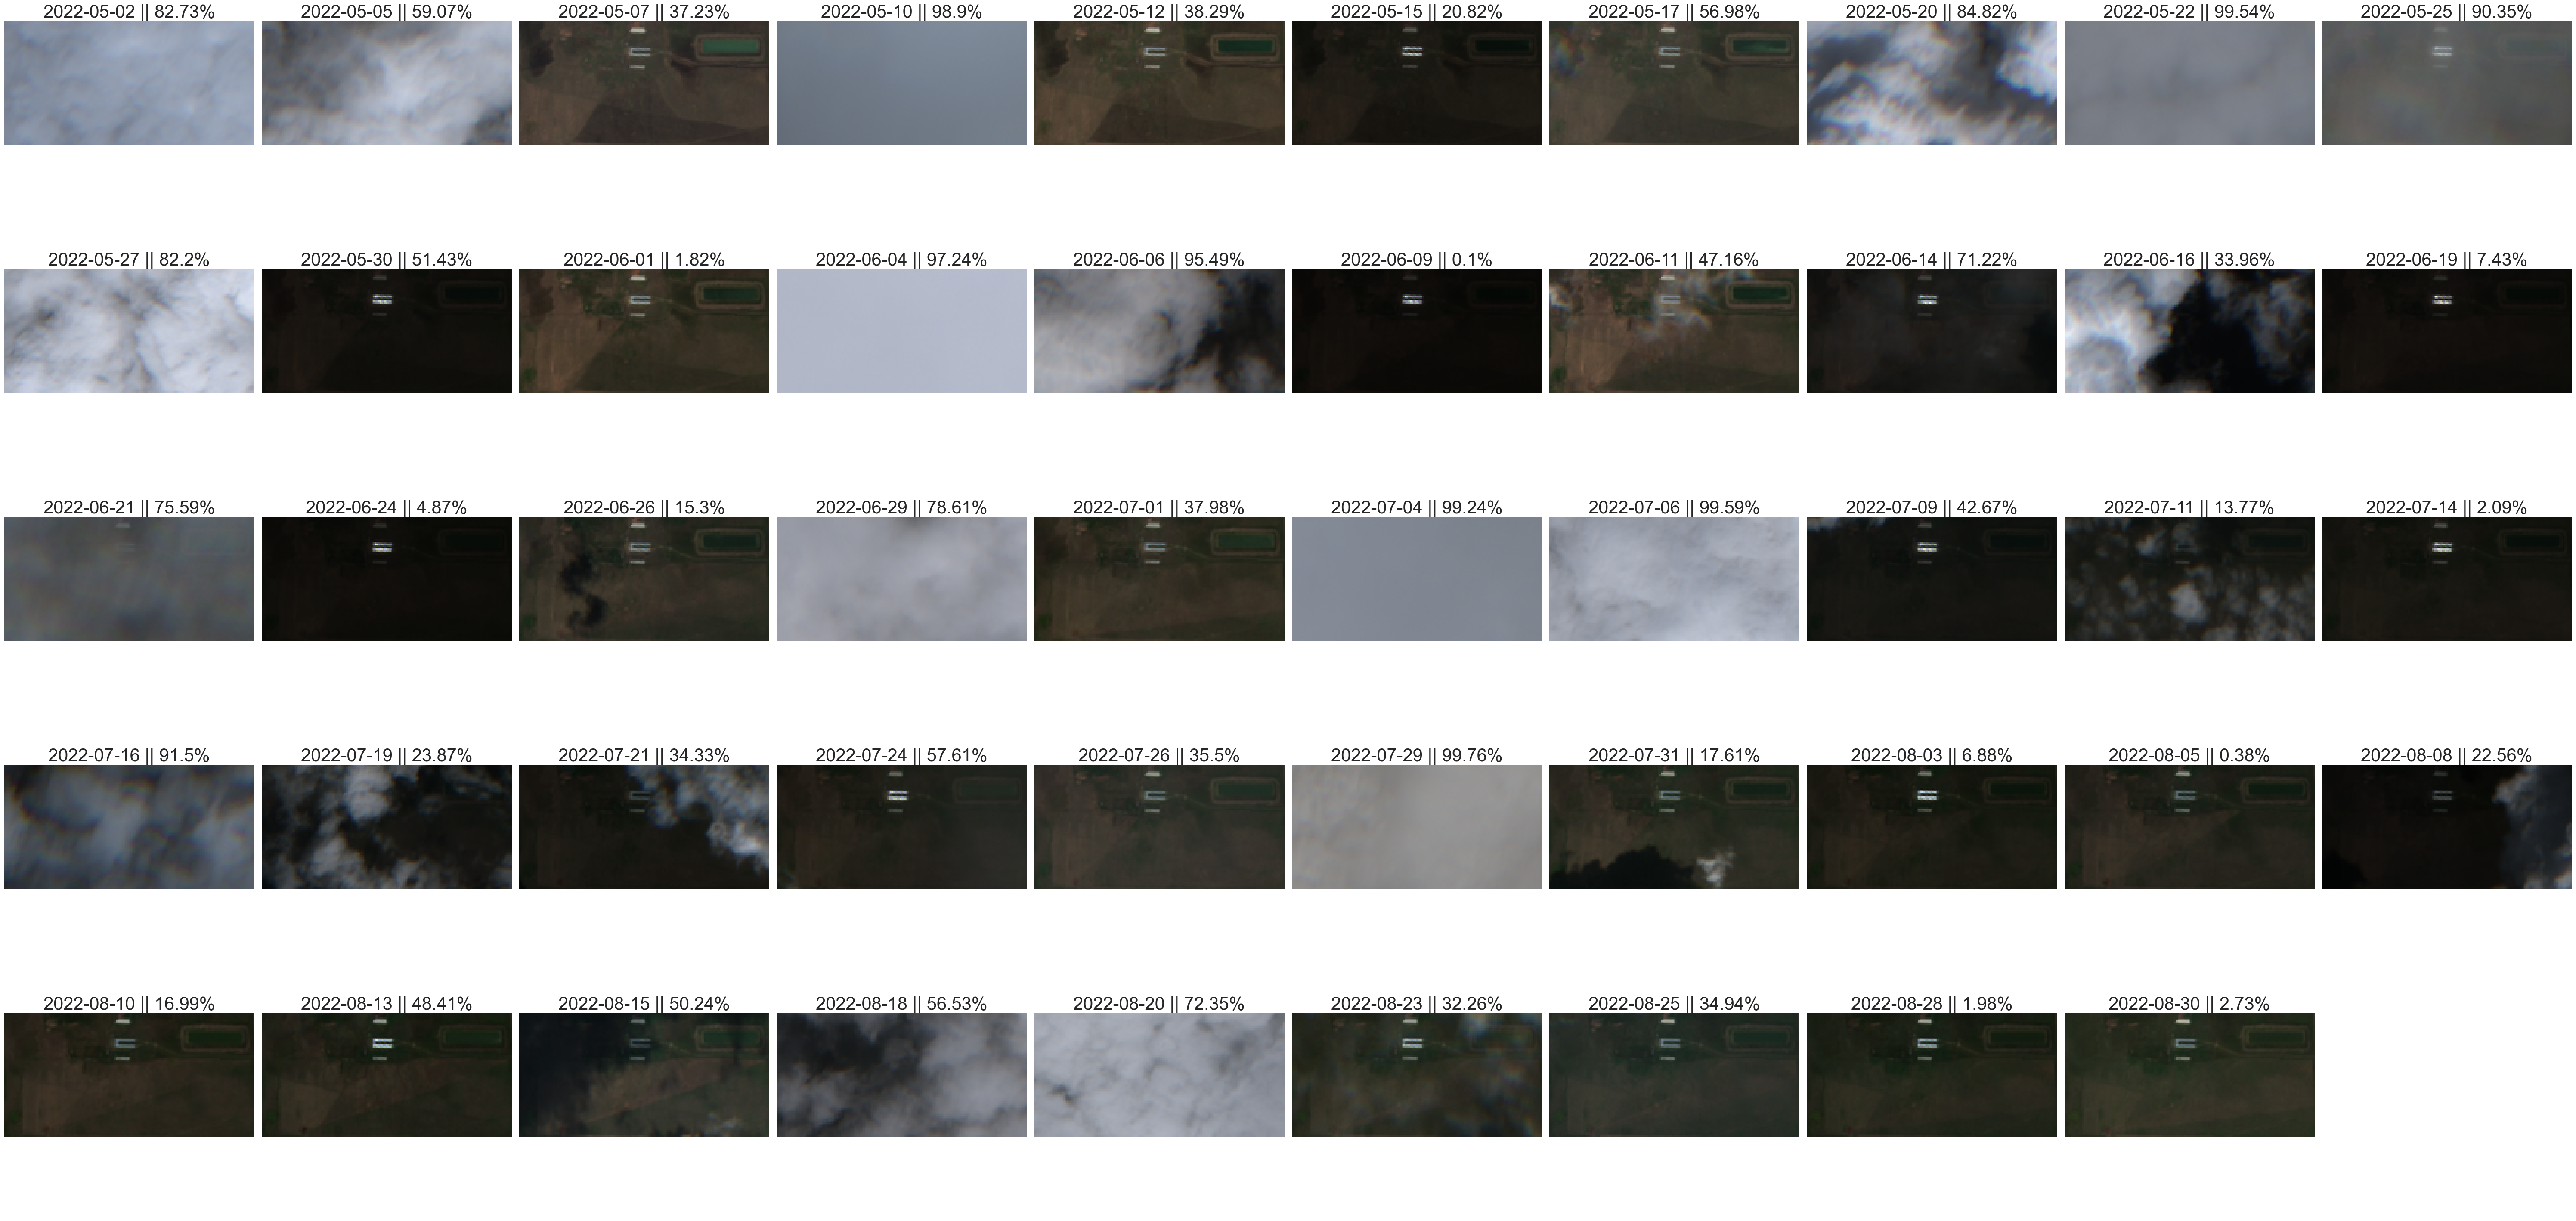

In [25]:
cols = 10
ncols, nrows = cols, ceil(len(results)/cols) 

fig, axis = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(60, 30), subplot_kw={"xticks": [], "yticks": [], "frame_on": False}
)

idx = 0
clear_date_dict = []
for i, (image, timestamp) in enumerate(zip(all_bands_data, unique_acquisitions)):

    data = image.astype(np.float64) / image.max()
    data = 255 * data
    image = data.astype(np.uint8)
    
    mx1 = ma.masked_array(image[:,:,bands_dict["B02"]], mask=combined_mask.reshape(aoi_height, aoi_width))
    mx2 = ma.masked_array(image[:,:,bands_dict["B03"]], mask=combined_mask.reshape(aoi_height, aoi_width))
    mx3 = ma.masked_array(image[:,:,bands_dict["B04"]], mask=combined_mask.reshape(aoi_height, aoi_width))
    comb = mx1&mx2&mx3
    white_image = comb >= white_noise_threshold
    if white_image.sum() <= white_noise_count:
        clear_date_dict.append((str(timestamp.date().isoformat()), i))
        ax = axis[idx // ncols][idx % ncols]
        image = np.stack([image[:,:,bands_dict["B04"]], image[:,:,bands_dict["B03"]], image[:,:,bands_dict["B02"]]])
        ax.imshow(np.transpose(image, (1, 2, 0)))
        ax.set_title(timestamp.date().isoformat()+ ' || ' + str(image_date_cloud[timestamp.date().isoformat()]) + "%", fontsize=30)
        idx += 1
        
clear_date_dict = dict(clear_date_dict)
plt.tight_layout()

# Анализ погодных параметров и каналов

## Координаты пастбища

In [26]:
longitude = pasture_bbox.geometry.centroid.coords.xy[0][0]
latitude = pasture_bbox.geometry.centroid.coords.xy[1][0]

In [27]:
forecast_parameters = [
"temperature_2m_max",
"temperature_2m_min",
"apparent_temperature_max",
"apparent_temperature_min",
"precipitation_sum",
"rain_sum",
"showers_sum",
"snowfall_sum",
"precipitation_hours",
"precipitation_probability_max",
"precipitation_probability_min",
"precipitation_probability_mean",
"weathercode",
"sunrise",
"sunset",
"windspeed_10m_max",
"windgusts_10m_max",
"winddirection_10m_dominant",
"shortwave_radiation_sum",
"et0_fao_evapotranspiration",
"uv_index_max",
"uv_index_clear_sky_max",]

history_parameters = [
"temperature_2m_max",
"temperature_2m_min",
"apparent_temperature_max",
"apparent_temperature_min",
"precipitation_sum",
"rain_sum",
"snowfall_sum",
"precipitation_hours",
"weathercode",
"sunrise",
"sunset",
"windspeed_10m_max",
"windgusts_10m_max",
"winddirection_10m_dominant",
"shortwave_radiation_sum",
"et0_fao_evapotranspiration",]


last_main_description = ""

def get_weather_mapping():
    global last_main_description
    
    url = "https://www.nodc.noaa.gov/archive/arc0021/0002199/1.1/data/0-data/HTML/WMO-CODE/WMO4677.HTM"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    weather_mapping = {}
    
    for i_table, table in enumerate(soup.select('table[BORDER]')):
        for i_row, row in enumerate(table.find_all('tr')[1:]):
            code_and_description = row.find_all('td')[:2]
            code = int(code_and_description[0].text.strip())
            description = code_and_description[1].text.strip()
            if not description.startswith("-"):
                last_main_description = description
            else:
                description = last_main_description
            weather_mapping[code] = description
            
            
    return weather_mapping

def weather_code_to_string(wmo_code):
    return weather_mapping.get(wmo_code, "Unknown Weather Code")

# Generate the weather mapping
weather_mapping = get_weather_mapping()


def apply_params_to_URL(URL, parameters):
    URL += "&daily="
    for i, parameter in enumerate(parameters):
        if i < len(parameters) - 1:
            URL += parameter + ","
        else:
            URL += parameter
    URL += "&timezone=auto"
    
    print("URL updated: ", URL)
    return URL

def make_API_request(URL):
    try:
        # Convert from bytes to text
        resp_text = urllib.request.urlopen(URL).read().decode('UTF-8')
        # Use loads to decode from text
        json_obj = json.loads(resp_text)
        print("Successfull API request!")
        return json_obj
    except urllib.error.HTTPError  as e:
        ErrorInfo= e.read().decode()
        print('Error code: ', e.code, ErrorInfo)
        sys.exit()
    except  urllib.error.URLError as e:
        ErrorInfo= e.read().decode()
        print('Error code: ', e.code,ErrorInfo)
        sys.exit()

# История погоды по заданному диапазону

In [28]:
start_date = time_interval[0]
end_date = time_interval[-1]

In [29]:
Hist_URL = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}"

In [30]:
Hist_URL = apply_params_to_URL(Hist_URL, history_parameters)

URL updated:  https://archive-api.open-meteo.com/v1/archive?latitude=54.21495200000001&longitude=69.52020049999999&start_date=2022-05-01&end_date=2022-08-31&daily=temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,weathercode,sunrise,sunset,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration&timezone=auto


In [31]:
history_json_obj = make_API_request(Hist_URL)

Successfull API request!


In [32]:
history_df = pd.DataFrame(history_json_obj["daily"])
history_df.drop(columns=["weathercode", "sunrise", "sunset"], inplace=True)

In [33]:
history_df

,time,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
0,2022-05-01,12.8,5.2,8.0,1.2,1.4,1.4,0.0,4.0,21.1,34,12.84,2.68
1,2022-05-02,12.0,1.1,7.9,-2.1,0.6,0.6,0.0,2.0,24.0,308,20.68,2.94
2,2022-05-03,14.3,-2.5,9.0,-6.5,0.0,0.0,0.0,0.0,18.1,278,21.98,3.78
3,2022-05-04,16.9,0.7,12.2,-3.4,0.0,0.0,0.0,0.0,17.7,144,22.59,4.39
4,2022-05-05,19.1,9.4,16.6,4.9,0.0,0.0,0.0,0.0,15.8,166,17.20,3.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,2022-08-27,22.0,13.8,21.4,11.1,0.0,0.0,0.0,0.0,15.8,6,15.83,3.29
119,2022-08-28,21.1,7.1,20.1,5.3,0.0,0.0,0.0,0.0,9.4,86,20.38,3.33
120,2022-08-29,27.2,9.5,26.3,7.6,0.0,0.0,0.0,0.0,13.7,237,19.64,4.13
121,2022-08-30,27.9,12.8,26.8,12.3,0.0,0.0,0.0,0.0,11.9,273,19.06,4.09


In [80]:
def get_main_weather_params_history(seek_date):
    if isinstance(seek_date, list):
        l = []
        for d in seek_date:
            l.append(round_up_to_hour(d))
        date_list_df = pd.DataFrame({'dt_iso': l})
        df = pd.merge(grand_history_weather_df, date_list_df, on='dt_iso', how='right')
        df = df.drop(columns=['dt', 'dt_iso', 'timezone', 'city_name', 'lat', 'lon', 'weather_id', 'weather_main', 'weather_description', 'weather_icon'])
    else:
        df = grand_history_weather_df[grand_history_weather_df["dt_iso"] == round_up_to_hour(seek_date)]
        df = df.drop(columns=['dt', 'dt_iso', 'timezone', 'city_name', 'lat', 'lon', 'weather_id', 'weather_main', 'weather_description', 'weather_icon'])
    return df.reset_index(drop=True)

def round_up_to_hour(timestamp):
    if timestamp.minute >= 30:
        # If minutes are above 30, round up to the next hour
        rounded_timestamp = timestamp.replace(
            minute=0, second=0, microsecond=0
        ) + timedelta(hours=1)
    else:
        # Otherwise, round down to the current hour
        rounded_timestamp = timestamp.replace(minute=0, second=0, microsecond=0)

    return rounded_timestamp.strftime('%Y-%m-%d %H:%M:%S %z %Z')

grand_history_weather_df = pd.read_csv('Pasture_Weather_History.csv')

In [123]:
def normalize_value(value, desired_min, desired_max):
    min_val = 39
    max_val = 56

    normalized_value = (value - min_val) / (max_val - min_val) * (desired_max - desired_min) + desired_min
    return normalized_value

pasture_median_value = [0.9519659876823425, 0.813551664352417]

# Дифференциальный анализ по дням

## Сравливание в загоне №6-7

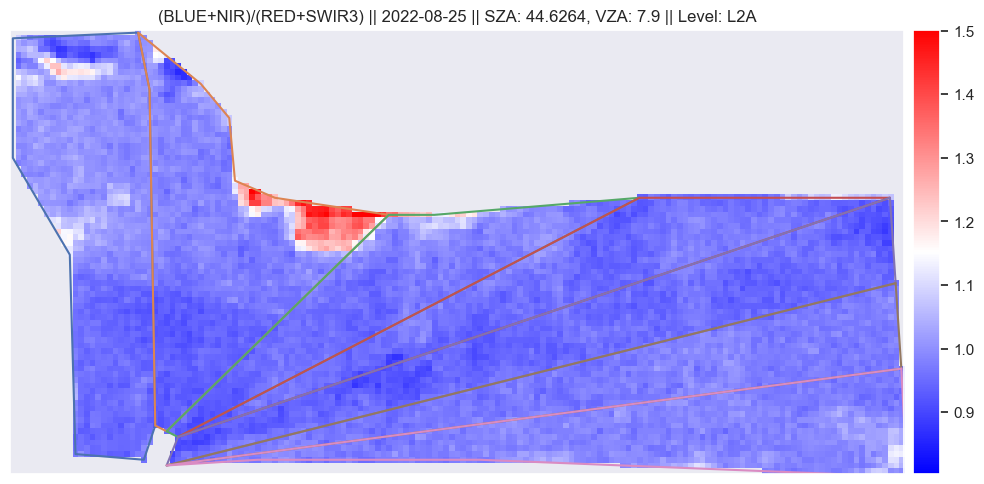

Загон,Сумма,Cреднаяя,Медианная,Макс,Мин,Площадь (га),Ресурс (т/га)
№1,1323.182617,0.992600,0.994300,1.264100,0.875300,13.330000,1.421300
№2,1262.808716,1.010200,0.978200,1.605500,0.859100,12.500000,1.278800
№3,837.642395,0.978600,0.969100,1.356600,0.896000,8.560000,1.197900
№4,911.994202,0.962000,0.961100,1.131400,0.871500,9.480000,1.127400
№5,1197.894653,0.947700,0.948400,1.069900,0.874600,12.640000,1.014400
№6,968.418823,0.975200,0.974800,1.025500,0.935600,9.930000,1.248600
№7,1104.539917,0.989700,0.986000,1.137100,0.937100,11.160000,1.348000
Пастбище,7606.481445,0.980200,0.972100,1.605500,0.859100,77.600000,8.636400


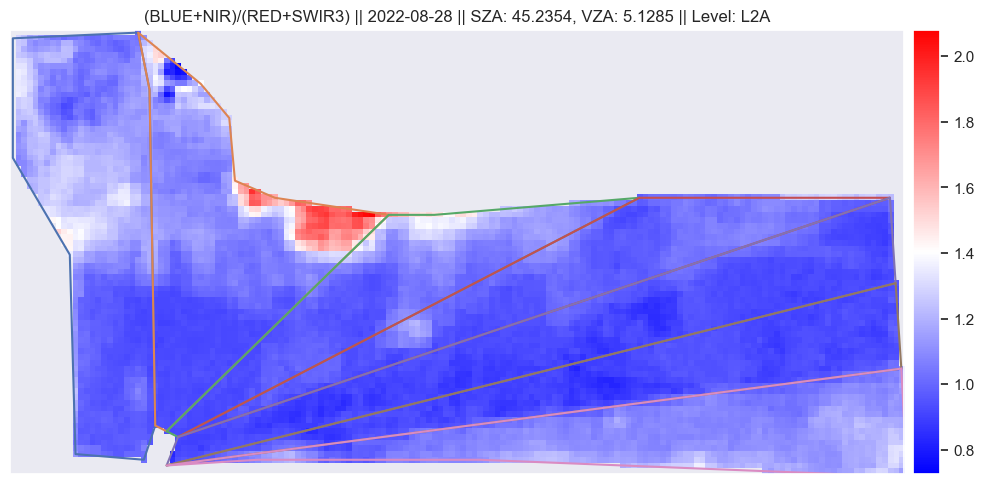

Загон,Сумма,Cреднаяя,Медианная,Макс,Мин,Площадь (га),Ресурс (т/га)
№1,1471.429688,1.103800,1.097700,1.522000,0.906500,13.330000,2.305800
№2,1405.195435,1.124200,1.069900,2.117200,0.738500,12.500000,2.058800
№3,909.635010,1.062700,1.033700,1.685300,0.906100,8.560000,1.738600
№4,956.625122,1.009100,0.998700,1.300900,0.887400,9.480000,1.428400
№5,1170.390137,0.925900,0.923700,1.224800,0.828500,12.640000,0.764200
№6,919.919495,0.926400,0.925100,1.113700,0.818300,9.930000,0.776900
№7,1234.872925,1.106500,1.098200,1.364800,0.899800,11.160000,2.309900
Пастбище,8068.067871,1.040100,1.004400,2.117200,0.738500,77.600000,11.382600


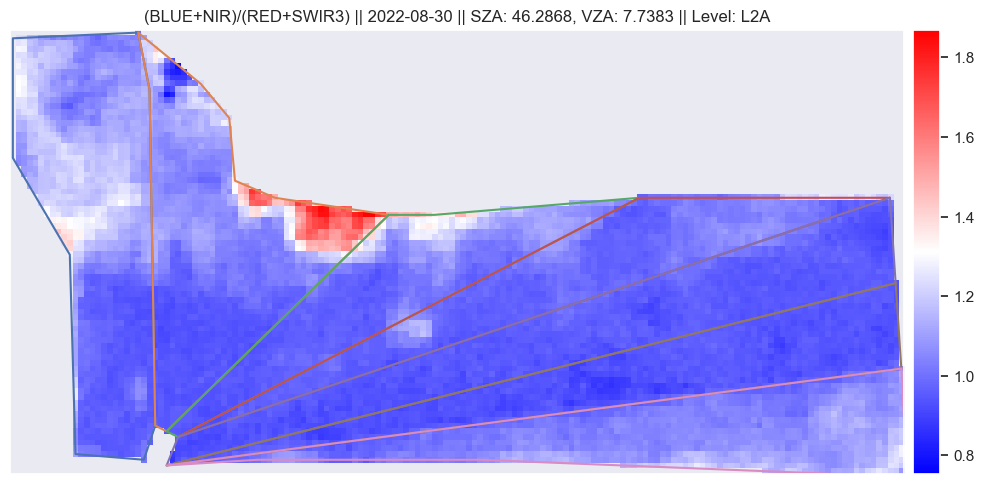

Загон,Сумма,Cреднаяя,Медианная,Макс,Мин,Площадь (га),Ресурс (т/га)
№1,1449.828247,1.087600,1.090200,1.444000,0.921100,13.330000,2.295400
№2,1362.771606,1.090200,1.037000,1.954800,0.787800,12.500000,1.823800
№3,890.878113,1.040700,1.003000,1.502300,0.916900,8.560000,1.523200
№4,951.104187,1.003300,0.986100,1.274400,0.907700,9.480000,1.373300
№5,1202.579346,0.951400,0.950000,1.227400,0.870500,12.640000,1.053400
№6,932.959595,0.939500,0.941000,1.065200,0.859400,9.930000,0.973600
№7,1183.399658,1.060400,1.052800,1.287100,0.927000,11.160000,1.963700
Пастбище,7973.520508,1.027800,0.987600,1.954800,0.787800,77.600000,11.006400


In [124]:
indices_dict = dict()
weather_cond_dict = {
    "pressure": [],
    "humidity": [],
    "temperature": [],
}
angles = {
    "SZA": [],
    "SAA": [],
    "VZM": [],
    "VAM": [],            
}

for date_chosen in ["2022-08-25", "2022-08-28", "2022-08-30"]:

    dt_object = datetime.datetime.strptime(date_chosen, "%Y-%m-%d")
    desired_time = datetime.timedelta(hours=6)
    desired_timezone = datetime.timezone.utc
    result_datetime = dt_object.replace(hour=7, minute=0, second=0, tzinfo=desired_timezone)
    alter_weather_param_df = get_main_weather_params_history(result_datetime)
    
    weather_cond_dict["temperature"].append(alter_weather_param_df["temp"].iloc[0])
    weather_cond_dict["pressure"].append(alter_weather_param_df["pressure"].iloc[0])
    weather_cond_dict["humidity"].append(alter_weather_param_df["humidity"].iloc[0])
    
    image_date = clear_date_dict[date_chosen]
    get_all_bands()
    precision = 4
    general_info = f"|| {date_chosen} || SZA: {str(round(SZA, precision))}, VZA: {str(round(VZM, precision))} || Level: {data_collection.processing_level}"
    
    input_text = "(BLUE+NIR)/(RED+SWIR3)"
#     input_text = "NIR"
    
    test_index = eval(input_text)
    
    test_thresh = test_index.min() 
    # test_thresh = (test_index.max() + test_index.min())/2

    test_filter = test_index >= test_thresh; test_mask = ~test_filter
    test_meet = ma.masked_array(test_index, mask=test_mask)
    
#     inverted_NIR = ~ (NIR == 1)
#     test_meet = ma.masked_array(test_meet, mask=inverted_NIR)
    
    # lower_bound = -1;  upper_bound = 1
    lower_bound = test_meet.min(); upper_bound = test_meet.max()
    
    
    if VZM < 6: 
        x = SZA + VZM + 2.6
    else: 
        x = SZA + VZM - 2.6;
        
    y = 0.02*x**2 -0.75*x + 46.06
    desired_median = normalize_value(y, min(pasture_median_value), max(pasture_median_value))
    current_median = ma.median(test_meet)
    coefficient = desired_median / current_median
    test_meet = test_meet * coefficient    
    
    
#     show_real_pasture()
    show_pasture_index(test_meet, lower_bound, upper_bound, show_hists=False, save_excel=False, show_index=True, show_table=True)
    
    indices_dict[date_chosen] = test_meet

    angles["SZA"].append(SZA);
    angles["SAA"].append(SAA);
    angles["VZM"].append(VZM);
    angles["VAM"].append(VAM);    

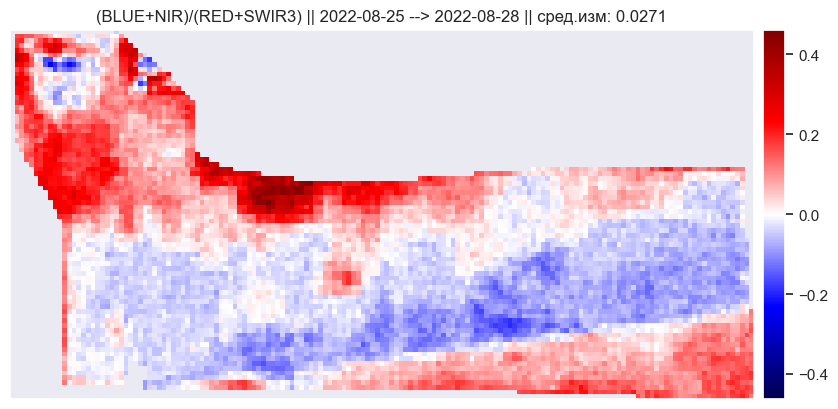

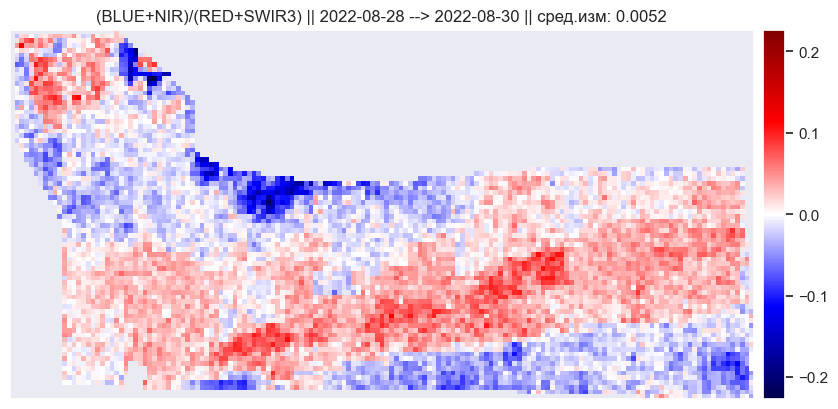

In [116]:
zagon = 0
day_change_diff_list = []

day_next, day_previous = "2022-08-28", "2022-08-25"
days_diff = change_difference(indices_dict[day_next] - indices_dict[day_previous], zagon)
ep.plot_bands(days_diff, title=f"{input_text} || {day_previous} --> {day_next} || сред.изм: {round(days_diff.mean(),precision)}", cmap="seismic", vmin=-np.max(np.abs(days_diff)), vmax=np.max(np.abs(days_diff)), figsize=(10, 14))
day_change_diff_list.append(days_diff.mean())

day_next, day_previous = "2022-08-30", "2022-08-28"
days_diff = change_difference(indices_dict[day_next] - indices_dict[day_previous], zagon)
ep.plot_bands(days_diff, title=f"{input_text} || {day_previous} --> {day_next} || сред.изм: {round(days_diff.mean(),precision)}", cmap="seismic", vmin=-np.max(np.abs(days_diff)), vmax=np.max(np.abs(days_diff)), figsize=(10, 14))
day_change_diff_list.append(days_diff.mean())

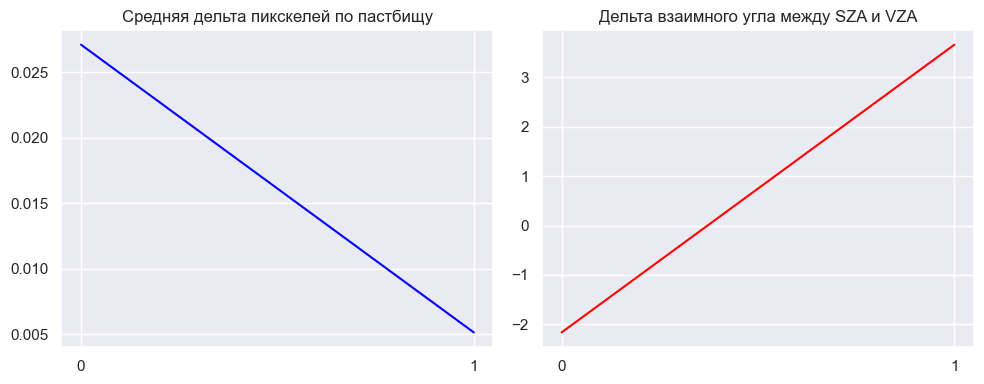

Корреляция delta: -0.9999999999999999


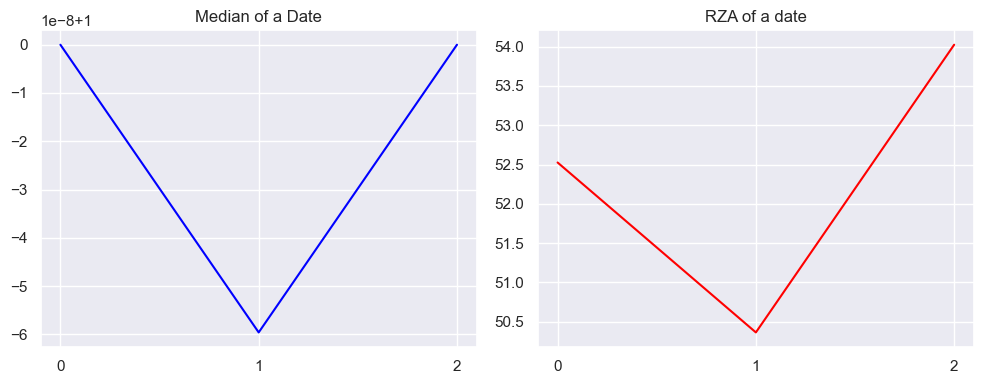

Корреляция angle-values: 0.9133686768705689
Корреляция T: 0.8873565094161138
Корреляция H: 0.12725695259515557
Корреляция P: -0.944911182523068


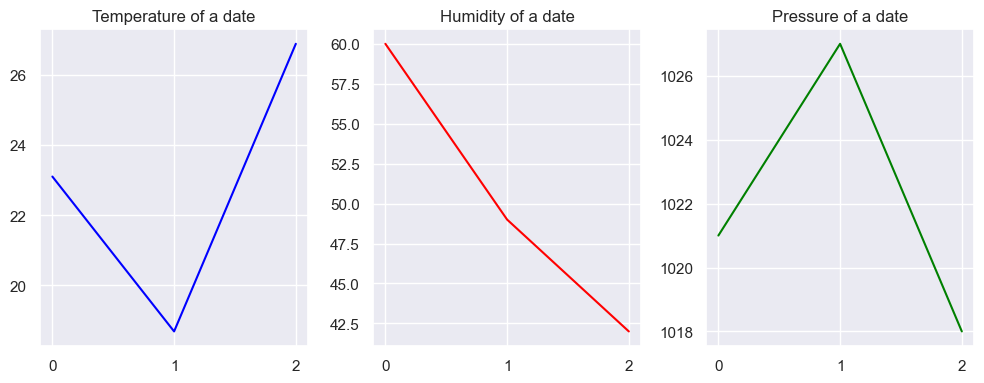

In [117]:
ZAS = [sum(pair) for pair in zip(angles["VZM"], angles["SZA"])]
AAD = [v-s for v, s in zip(angles["VAM"], angles["SAA"])]
ZAS_diff = [ZAS[i + 1] - ZAS[i] for i in range(len(ZAS) - 1)]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(day_change_diff_list, color='blue')
axes[0].set_title('Средняя дельта пикскелей по пастбищу')
axes[0].set_xticks(list(range(len(day_change_diff_list))))

axes[1].plot(ZAS_diff, color='red')
axes[1].set_title('Дельта взаимного угла между SZA и VZA')
axes[1].set_xticks(list(range(len(ZAS_diff))))

plt.tight_layout()

plt.show()

print(f"Корреляция delta: {np.corrcoef(ZAS_diff, day_change_diff_list)[0, 1]}")



fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

list_of_values = [ ma.median(index) for index in indices_dict.values()]
axes[0].plot(list_of_values, color='blue')
axes[0].set_title('Median of a Date')
axes[0].set_xticks(list(range(len(list_of_values))))

axes[1].plot(ZAS, color='red')
axes[1].set_title('RZA of a date')
axes[1].set_xticks(list(range(len(ZAS))))

plt.tight_layout()

plt.show()

print(f"Корреляция angle-values: {np.corrcoef(ZAS, list_of_values)[0, 1]}")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

axes[0].plot(weather_cond_dict["temperature"], color='blue')
axes[0].set_title('Temperature of a date')
axes[0].set_xticks(list(range(len(weather_cond_dict["temperature"]))))
print(f'Корреляция T: {np.corrcoef(weather_cond_dict["temperature"], list_of_values)[0, 1]}')

axes[1].plot(weather_cond_dict["humidity"], color='red')
axes[1].set_title('Humidity of a date')
axes[1].set_xticks(list(range(len(weather_cond_dict["humidity"]))))
print(f'Корреляция H: {np.corrcoef(weather_cond_dict["humidity"], list_of_values)[0, 1]}')

axes[2].plot(weather_cond_dict["pressure"], color='green')
axes[2].set_title('Pressure of a date')
axes[2].set_xticks(list(range(len(weather_cond_dict["pressure"]))))
print(f'Корреляция P: {np.corrcoef(weather_cond_dict["pressure"], list_of_values)[0, 1]}')

plt.tight_layout()

plt.show()

# print(f"Корреляция: {np.corrcoef(ZAS_diff, day_change_diff_list)[0, 1]}")

## Стравливание в загоне №3-4

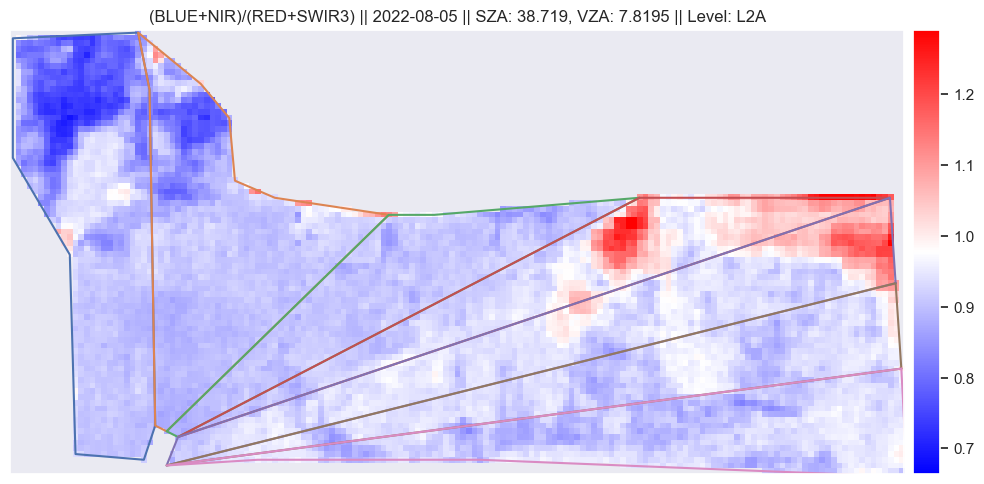

Загон,Сумма,Cреднаяя,Медианная,Макс,Мин,Площадь (га),Ресурс (т/га)
№1,1159.108032,0.869500,0.894900,1.080200,0.687700,13.330000,0.605200
№2,1115.781738,0.892600,0.899300,1.150900,0.722600,12.500000,0.643700
№3,775.699402,0.906200,0.906900,1.125000,0.833500,8.560000,0.711500
№4,938.416016,0.989900,0.959300,1.338100,0.869500,9.480000,1.174900
№5,1219.631348,0.964900,0.946500,1.303600,0.849900,12.640000,1.062000
№6,924.288574,0.930800,0.934300,1.100900,0.839100,9.930000,0.953500
№7,1025.599976,0.919000,0.922600,1.018700,0.822300,11.160000,0.849900
Пастбище,7158.525391,0.922300,0.917100,1.338100,0.687700,77.600000,6.000700


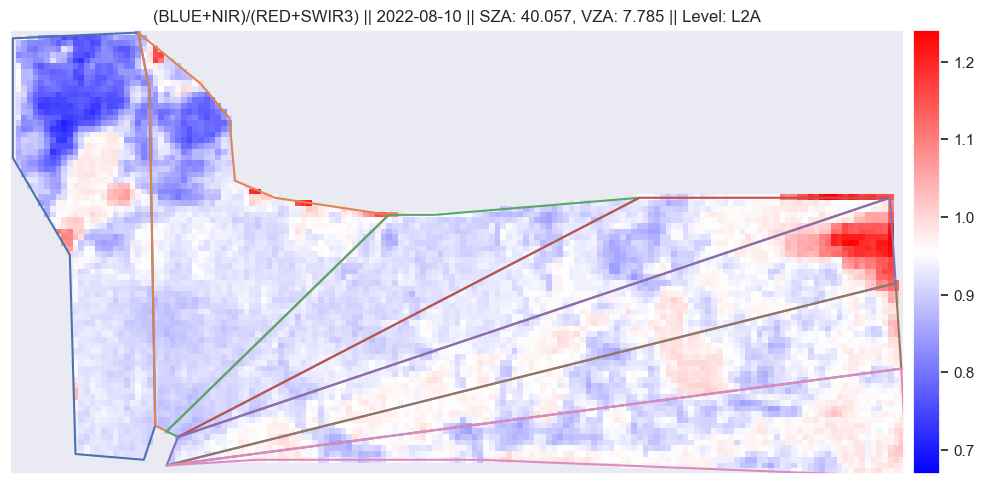

Загон,Сумма,Cреднаяя,Медианная,Макс,Мин,Площадь (га),Ресурс (т/га)
№1,1185.530762,0.889400,0.910600,1.108400,0.705900,13.330000,0.742400
№2,1138.712402,0.911000,0.916500,1.211800,0.756100,12.500000,0.794400
№3,784.657288,0.916700,0.917100,1.102500,0.852200,8.560000,0.799800
№4,886.731506,0.935400,0.933200,1.277100,0.841600,9.480000,0.942400
№5,1222.763916,0.967400,0.953700,1.309700,0.856000,12.640000,1.124100
№6,939.172729,0.945800,0.948200,1.126400,0.856400,9.930000,1.075200
№7,1047.827881,0.938900,0.943800,1.026500,0.847900,11.160000,1.036200
Пастбище,7205.396484,0.928400,0.928100,1.309700,0.705900,77.600000,6.514500


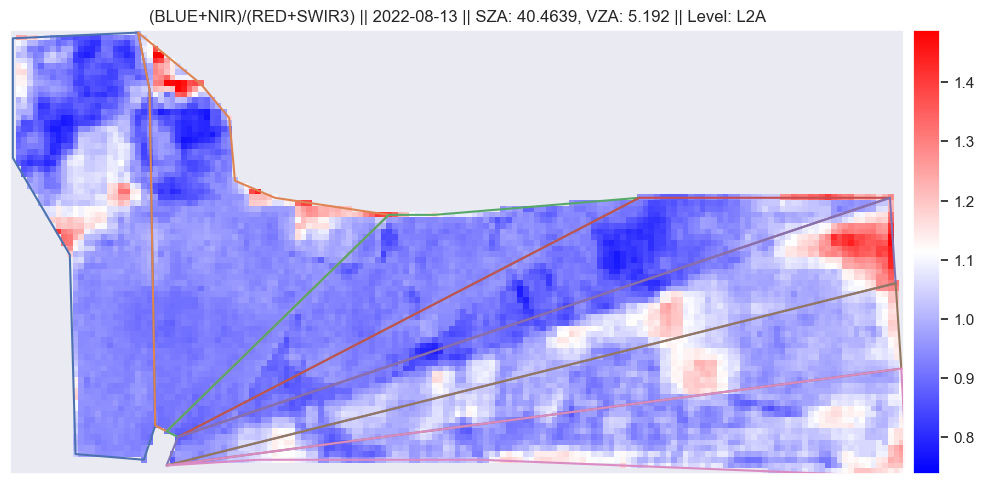

Загон,Сумма,Cреднаяя,Медианная,Макс,Мин,Площадь (га),Ресурс (т/га)
№1,1278.836182,0.959400,0.945100,1.406700,0.773300,13.330000,1.058500
№2,1200.336304,0.960300,0.938600,1.520600,0.764000,12.500000,1.001800
№3,798.872986,0.933300,0.932500,1.394900,0.835700,8.560000,0.946900
№4,871.476318,0.919300,0.914400,1.401400,0.775500,9.480000,0.787000
№5,1304.289185,1.031900,1.008200,1.542200,0.780600,12.640000,1.618200
№6,1011.175903,1.018300,1.000700,1.310000,0.863400,9.930000,1.551100
№7,1128.857178,1.011500,1.004700,1.263300,0.853400,11.160000,1.586800
Пастбище,7593.843750,0.978300,0.955600,1.542200,0.764000,77.600000,8.550300


In [125]:
indices_dict = dict()
weather_cond_dict = {
    "pressure": [],
    "humidity": [],
    "temperature": [],
}
angles = {
    "SZA": [],
    "SAA": [],
    "VZM": [],
    "VAM": [],            
}


for date_chosen in ["2022-08-05", "2022-08-10", "2022-08-13"]:

    dt_object = datetime.datetime.strptime(date_chosen, "%Y-%m-%d")
    desired_time = datetime.timedelta(hours=6)
    desired_timezone = datetime.timezone.utc
    result_datetime = dt_object.replace(hour=7, minute=0, second=0, tzinfo=desired_timezone)
    alter_weather_param_df = get_main_weather_params_history(result_datetime)
    
    weather_cond_dict["temperature"].append(alter_weather_param_df["temp"].iloc[0])
    weather_cond_dict["pressure"].append(alter_weather_param_df["pressure"].iloc[0])
    weather_cond_dict["humidity"].append(alter_weather_param_df["humidity"].iloc[0])
    
    image_date = clear_date_dict[date_chosen]
    get_all_bands()
    precision = 4
    general_info = f"|| {date_chosen} || SZA: {str(round(SZA, precision))}, VZA: {str(round(VZM, precision))} || Level: {data_collection.processing_level}"
    
    input_text = "(BLUE+NIR)/(RED+SWIR3)"
#     input_text = "NIR"
    
    test_index = eval(input_text)
    
    test_thresh = test_index.min() 
    # test_thresh = (test_index.max() + test_index.min())/2

    test_filter = test_index >= test_thresh; test_mask = ~test_filter
    test_meet = ma.masked_array(test_index, mask=test_mask)
    
#     inverted_NIR = ~ (NIR == 1)
#     test_meet = ma.masked_array(test_meet, mask=inverted_NIR)
    
    # lower_bound = -1;  upper_bound = 1
    lower_bound = test_meet.min(); upper_bound = test_meet.max()

    
    if VZM < 6: 
        x = SZA + VZM + 2.6
    else: 
        x = SZA + VZM - 2.6;
        
    y = 0.02*x**2 -0.75*x + 46.06
    desired_median = normalize_value(y, min(pasture_median_value), max(pasture_median_value))
    current_median = ma.median(test_meet)
    coefficient = desired_median / current_median
    test_meet = test_meet * coefficient        
    
    
#     show_real_pasture()
    show_pasture_index(test_meet, lower_bound, upper_bound, show_hists=False, save_excel=False, show_index=True, show_table=True)
    
    indices_dict[date_chosen] = test_meet
    
    angles["SZA"].append(SZA);
    angles["SAA"].append(SAA);
    angles["VZM"].append(VZM);
    angles["VAM"].append(VAM);    

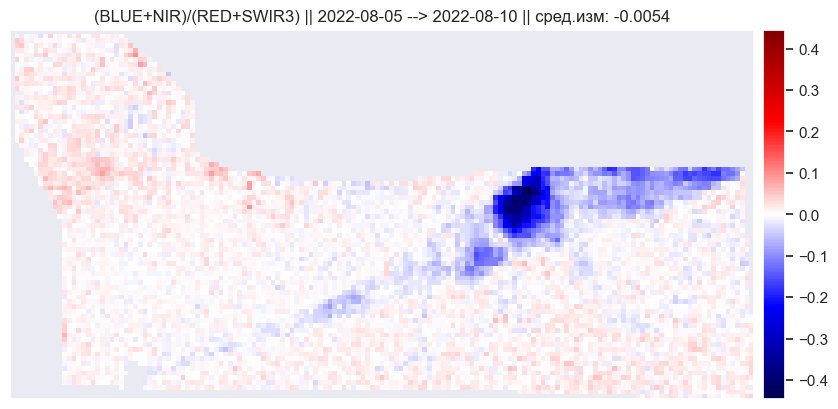

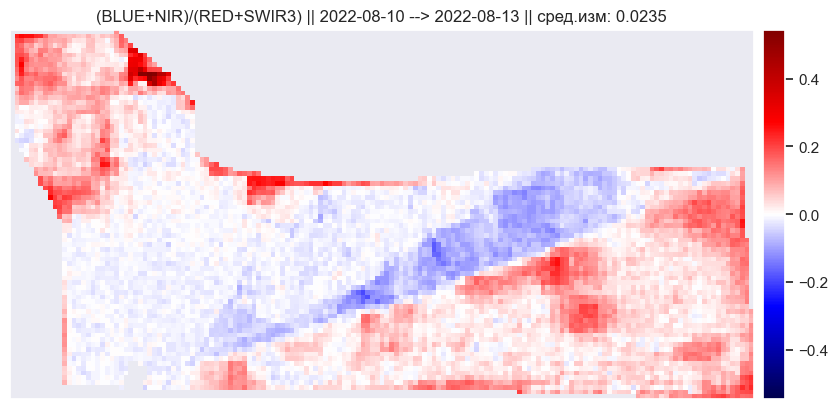

In [119]:
zagon = 0
day_change_diff_list = []

day_next, day_previous = "2022-08-10", "2022-08-05"
days_diff = change_difference(indices_dict[day_next] - indices_dict[day_previous], zagon)
ep.plot_bands(days_diff, title=f"{input_text} || {day_previous} --> {day_next} || сред.изм: {round(days_diff.mean(),precision)}", cmap="seismic", vmin=-np.max(np.abs(days_diff)), vmax=np.max(np.abs(days_diff)), figsize=(10, 14))
day_change_diff_list.append(days_diff.mean())

day_next, day_previous = "2022-08-13", "2022-08-10"
days_diff = change_difference(indices_dict[day_next] - indices_dict[day_previous], zagon)
ep.plot_bands(days_diff, title=f"{input_text} || {day_previous} --> {day_next} || сред.изм: {round(days_diff.mean(),precision)}", cmap="seismic", vmin=-np.max(np.abs(days_diff)), vmax=np.max(np.abs(days_diff)), figsize=(10, 14))
day_change_diff_list.append(days_diff.mean())

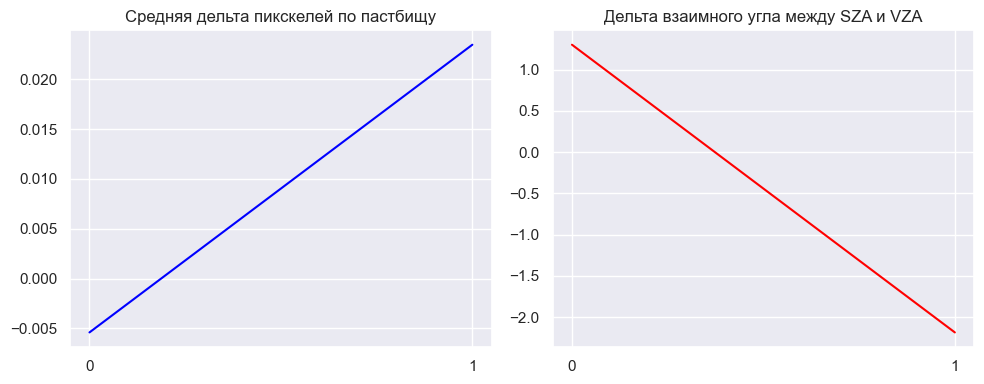

Корреляция delta: -1.0


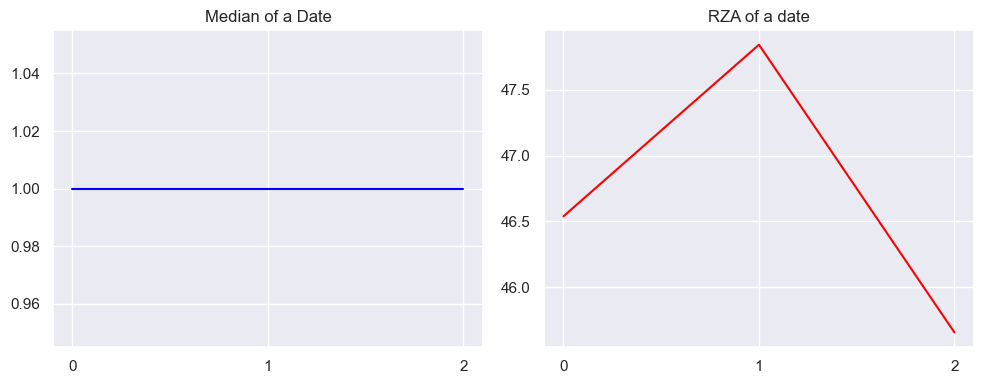

Корреляция angle-values: nan
Корреляция T: nan
Корреляция H: nan
Корреляция P: nan


C:\ProgramData\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\ProgramData\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


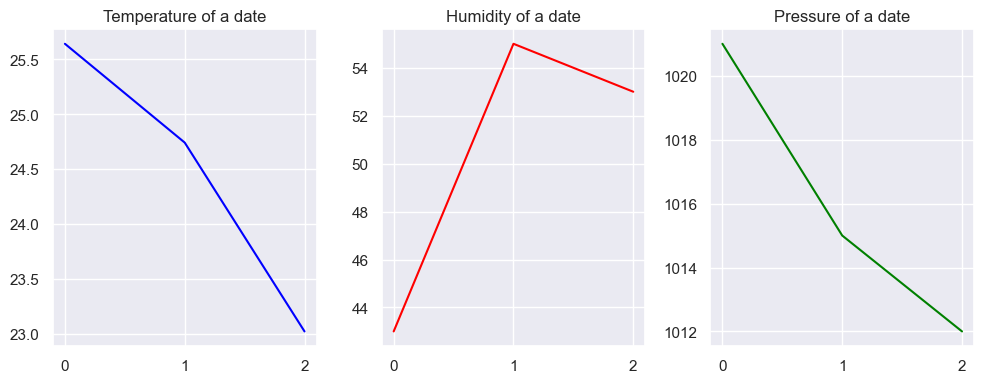

In [120]:
ZAS = [sum(pair) for pair in zip(angles["VZM"], angles["SZA"])]
AAD = [v-s for v, s in zip(angles["VAM"], angles["SAA"])]
ZAS_diff = [ZAS[i + 1] - ZAS[i] for i in range(len(ZAS) - 1)]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(day_change_diff_list, color='blue')
axes[0].set_title('Средняя дельта пикскелей по пастбищу')
axes[0].set_xticks(list(range(len(day_change_diff_list))))

axes[1].plot(ZAS_diff, color='red')
axes[1].set_title('Дельта взаимного угла между SZA и VZA')
axes[1].set_xticks(list(range(len(ZAS_diff))))

plt.tight_layout()

plt.show()

print(f"Корреляция delta: {np.corrcoef(ZAS_diff, day_change_diff_list)[0, 1]}")



fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

list_of_values = [ ma.median(index) for index in indices_dict.values()]
axes[0].plot(list_of_values, color='blue')
axes[0].set_title('Median of a Date')
axes[0].set_xticks(list(range(len(list_of_values))))

axes[1].plot(ZAS, color='red')
axes[1].set_title('RZA of a date')
axes[1].set_xticks(list(range(len(ZAS))))

plt.tight_layout()

plt.show()

print(f"Корреляция angle-values: {np.corrcoef(ZAS, list_of_values)[0, 1]}")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

axes[0].plot(weather_cond_dict["temperature"], color='blue')
axes[0].set_title('Temperature of a date')
axes[0].set_xticks(list(range(len(weather_cond_dict["temperature"]))))
print(f'Корреляция T: {np.corrcoef(weather_cond_dict["temperature"], list_of_values)[0, 1]}')

axes[1].plot(weather_cond_dict["humidity"], color='red')
axes[1].set_title('Humidity of a date')
axes[1].set_xticks(list(range(len(weather_cond_dict["humidity"]))))
print(f'Корреляция H: {np.corrcoef(weather_cond_dict["humidity"], list_of_values)[0, 1]}')

axes[2].plot(weather_cond_dict["pressure"], color='green')
axes[2].set_title('Pressure of a date')
axes[2].set_xticks(list(range(len(weather_cond_dict["pressure"]))))
print(f'Корреляция P: {np.corrcoef(weather_cond_dict["pressure"], list_of_values)[0, 1]}')

plt.tight_layout()

plt.show()

# print(f"Корреляция: {np.corrcoef(ZAS_diff, day_change_diff_list)[0, 1]}")